In [2]:
import numpy as np
import pandas as pd
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# load in data
df2021 = pd.read_csv('2021VAERSSYMPTOMS.csv')
df2022 = pd.read_csv('2022VAERSSYMPTOMS.csv')
dfsymptoms = pd.concat([df2021, df2022], axis=0)

In [3]:
# combine duplicate rows in SYMPTOMS file
dfsymptoms_merged = dfsymptoms.groupby(['VAERS_ID'])[['SYMPTOM1','SYMPTOMVERSION1', 'SYMPTOM2', 'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3', 'SYMPTOM4', 'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5']].agg(set)

In [4]:
# merge VAX and SYMPTOMS files based on repetitions VAX file
dfvax2021 = pd.read_csv('2021VAERSVAX.csv')
dfvax2022 = pd.read_csv('2022VAERSVAX.csv')
dfvax = pd.concat([dfvax2021, dfvax2022], axis=0)
dfmerged = pd.merge(dfvax, dfsymptoms, how="outer", on="VAERS_ID")
dfmerged.head(1)

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,910642,COVID19,PFIZER\BIONTECH,EJ1685,1,NaN,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),Dyspnoea,25.0,Heart rate increased,25.0,SARS-CoV-2 test negative,25.0,NaN,NaN,NaN,NaN


In [6]:
# extracting SYMPTOM columns
dfmerged_symp = dfmerged[["VAERS_ID","VAX_MANU","SYMPTOM1","SYMPTOM2","SYMPTOM3","SYMPTOM4","SYMPTOM5"]]

In [7]:
# merge symptoms into one column
dfmerged["ALLSYMPTOMS"] = dfmerged["SYMPTOM1"].str.cat(dfmerged_symp[["SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]].astype(str), sep=",")

In [8]:
dfmerged_symp = dfmerged.loc(axis=1)[["VAERS_ID","VAX_MANU","ALLSYMPTOMS"]]
dfmerged_symp.head()

,VAERS_ID,VAX_MANU,ALLSYMPTOMS
0,910642,PFIZER\BIONTECH,"Dyspnoea,Heart rate increased,SARS-CoV-2 test ..."
1,916600,MODERNA,"Dysphagia,Epiglottitis,nan,nan,nan"
2,916601,MODERNA,"Anxiety,Dyspnoea,nan,nan,nan"
3,916602,PFIZER\BIONTECH,"Chest discomfort,Dysphagia,Pain in extremity,V..."
4,916603,MODERNA,"Dizziness,Fatigue,Mobility decreased,nan,nan"


In [9]:
# group into the top five firms
dfpbt = dfmerged_symp[dfmerged_symp['VAX_MANU'] == 'PFIZER\BIONTECH'].reset_index(drop=True)
dfmoderna = dfmerged_symp[dfmerged_symp['VAX_MANU'] == 'MODERNA'].reset_index(drop=True)
dfjanssen = dfmerged_symp[dfmerged_symp['VAX_MANU'] == 'JANSSEN'].reset_index(drop=True)
dfgsk = dfmerged_symp[dfmerged_symp['VAX_MANU'] == 'GLAXOSMITHKLINE BIOLOGICALS'].reset_index(drop=True)
dfmerck = dfmerged_symp[dfmerged_symp['VAX_MANU'] == 'MERCK & CO. INC.'].reset_index(drop=True)

In [10]:
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from gensim import corpora, models
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
# convert df to string type
pfizer = dfpbt['ALLSYMPTOMS'].astype(str)
moderna = dfmoderna['ALLSYMPTOMS'].astype(str)
janssen = dfjanssen['ALLSYMPTOMS'].astype(str)
gsk = dfgsk['ALLSYMPTOMS'].astype(str)
merck = dfmerck['ALLSYMPTOMS'].astype(str)

In [12]:
newstop = ['could','within','us','doctor','medical','day','moderna','pfizer','patient', 
           'vaccine','report','reports','gsk','janssen','merck','get','got','lot','left',
           'right','like','went','take','note','notes','given','receive','receiving',
           'reporting','reported','received','unspecific','unspecified','unknown','pt','non',
           'caller','number','reporter','state','call','start','feel','date','report',
           'administered','season','could','within','report','nan','in','of','no','to']
#dose (just to see what happens)

In [19]:
## cleaning data: PFIZER

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list + new words
en_stop = [nltk.corpus.stopwords.words('english'),
           'could','within','us','doctor','medical','day','moderna','pfizer','patient', 
           'vaccine', 'report', 'reports','gsk', 'janssen','merck','get','got','lot','left',
           'right','like','went','take','note','notes','given','receive','receiving',
           'reporting','reported','received','unspecific','unspecified','unknown','pt','non',
           'caller','number','reporter','state','call','start','feel','date','report',
           'administered','season','could','within','report','nan','in','of']

lemmatizer = WordNetLemmatizer()

# list for tokenized documents in loop
textspbt = []

# loop through document list
for i in pfizer:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop] 
    
    # remove numbers from tokens    
    letter_tokens = [i for i in stopped_tokens if not any(filter(str.isdigit, i))]
    
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(i) for i in letter_tokens]

    # add tokens to list
    textspbt.append(lemma_tokens)

# convert the List of Lists to a Tuple of Tuples (so that it is hashable for counting)
#pbtclean = tuple(map(tuple, textspbt))

# Combine list of lists into one list
import itertools
pbtclean = list(itertools.chain.from_iterable(textspbt))

# count most frequent 10 words
from collections import Counter
pbtcounts = Counter(pbtclean).most_common(10)
print(pbtcounts)

[('pain', 176107), ('test', 111424), ('cov', 65905), ('sars', 65904), ('blood', 64805), ('headache', 64669), ('covid', 58851), ('product', 58542), ('fatigue', 57797), ('pyrexia', 52094)]


In [18]:
## cleaning data: MODERNA

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list + new words
en_stop = [nltk.corpus.stopwords.words('english'),
           'could','within','us','doctor','medical','day','moderna','pfizer','patient', 
           'vaccine', 'report', 'reports','gsk', 'janssen','merck','get','got','lot','left',
           'right','like','went','take','note','notes','given','receive','receiving',
           'reporting','reported','received','unspecific','unspecified','unknown','pt','non',
           'caller','number','reporter','state','call','start','feel','date','report',
           'administered','season','could','within','report','nan','in','of','no','to']

lemmatizer = WordNetLemmatizer()

# list for tokenized documents in loop
textsmoderna = []

# loop through document list
for i in moderna:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop] 
    
    # remove numbers from tokens    
    letter_tokens = [i for i in stopped_tokens if not any(filter(str.isdigit, i))]
    
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(i) for i in letter_tokens]

    # add tokens to list
    textsmoderna.append(lemma_tokens)
    
# convert the List of Lists to a Tuple of Tuples (so that it is hashable for counting)
#modernaclean = tuple(map(tuple, textsmoderna))

# Combine list of lists into one list
import itertools
modernaclean = list(itertools.chain.from_iterable(textsmoderna))

# count most frequent 10 words
from collections import Counter
modernacounts = Counter(modernaclean).most_common(10)
print(modernacounts)

[('pain', 180404), ('site', 165807), ('injection', 130778), ('product', 74873), ('test', 73374), ('headache', 65484), ('pyrexia', 61533), ('fatigue', 58995), ('swelling', 57630), ('rash', 54413)]


In [17]:
## cleaning data: JANSSEN

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list + new words
en_stop = [nltk.corpus.stopwords.words('english'),
            'could','within','us','doctor','medical','day','moderna','pfizer','patient', 
           'vaccine', 'report', 'reports','gsk', 'janssen','merck','get','got','lot','left',
           'right','like','went','take','note','notes','given','receive','receiving',
           'reporting','reported','received','unspecific','unspecified','unknown','pt','non',
           'caller','number','reporter','state','call','start','feel','date','report',
           'administered','season','could','within','report','nan','in','of','no','to']
           
lemmatizer = WordNetLemmatizer()

# list for tokenized documents in loop
textsjanssen = []

# loop through document list
for i in janssen:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop] 
    
    # remove numbers from tokens    
    letter_tokens = [i for i in stopped_tokens if not any(filter(str.isdigit, i))]
    
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(i) for i in letter_tokens]

    # add tokens to list
    textsjanssen.append(lemma_tokens)
    
# convert the List of Lists to a Tuple of Tuples (so that it is hashable for counting)
#janssenclean = tuple(map(tuple, textsjanssen))

# Combine list of lists into one list    
import itertools 
janssenclean = list(itertools.chain.from_iterable(textsjanssen))

# count most frequent 10 words
from collections import Counter
janssencounts = Counter(janssenclean).most_common(10)
print(janssencounts)

[('pain', 34274), ('headache', 16739), ('test', 14514), ('pyrexia', 14065), ('chill', 11753), ('fatigue', 11704), ('blood', 11096), ('dizziness', 8838), ('normal', 8455), ('nausea', 8443)]


In [13]:
## cleaning data: GSK

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list + new words
en_stop = [nltk.corpus.stopwords.words('english'),
            'could','within','us','doctor','medical','day','moderna','pfizer','patient', 
           'vaccine', 'report', 'reports','gsk', 'janssen','merck','get','got','lot','left',
           'right','like','went','take','note','notes','given','receive','receiving',
           'reporting','reported','received','unspecific','unspecified','unknown','pt','non',
           'caller','number','reporter','state','call','start','feel','date','report',
           'administered','season','could','within','report','nan','in','of','no','to']
    

lemmatizer = WordNetLemmatizer()

# list for tokenized documents in loop
textsgsk= []

# loop through document list
for i in gsk:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop] 
    
    # remove numbers from tokens    
    letter_tokens = [i for i in stopped_tokens if not any(filter(str.isdigit, i))]
    
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(i) for i in letter_tokens]

    # add tokens to list
    textsgsk.append(lemma_tokens)
    
# Combine list of lists into one list    
import itertools 
gskclean = list(itertools.chain.from_iterable(textsgsk))

# convert the List of Lists to a Tuple of Tuples (so that it is hashable for counting)
#gskclean = tuple(map(tuple, textsgsk))

# count most frequent 10 words
from collections import Counter
gskcounts = Counter(gskclean).most_common(10)
print(gskcounts)

In [16]:
## cleaning data: MERCK

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list + new words
en_stop = [nltk.corpus.stopwords.words('english'),
            'could','within','us','doctor','medical','day','moderna','pfizer','patient', 
           'vaccine', 'report', 'reports','gsk', 'janssen','merck','get','got','lot','left',
           'right','like','went','take','note','notes','given','receive','receiving',
           'reporting','reported','received','unspecific','unspecified','unknown','pt','non',
           'caller','number','reporter','state','call','start','feel','date','report',
           'administered','season','could','within','report','nan','in','of','no','to']

lemmatizer = WordNetLemmatizer()

# list for tokenized documents in loop
textsmerck= []

# loop through document list
for i in merck:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop] 
    
    # remove numbers from tokens    
    letter_tokens = [i for i in stopped_tokens if not any(filter(str.isdigit, i))]
    
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(i) for i in letter_tokens]

    # add tokens to list
    textsmerck.append(lemma_tokens)
    
# convert the List of Lists to a Tuple of Tuples (so that it is hashable for counting)
#merckclean = tuple(map(tuple, textsmerck))

# Combine list of lists into one list    
import itertools 
merckclean = list(itertools.chain.from_iterable(textsmerck))

# count most frequent 10 words
from collections import Counter
merckcounts = Counter(merckclean).most_common(10)
print(merckcounts)

[('product', 10737), ('event', 6373), ('adverse', 6243), ('error', 4908), ('storage', 4632), ('site', 4098), ('injection', 3956), ('pain', 2973), ('rash', 2310), ('inappropriate', 2067)]


  MedDRA Code     Count
0        pain  176107.0
1        test  111424.0
2         cov   65905.0
3        sars   65904.0
4       blood   64805.0
5    headache   64669.0
6       covid   58851.0
7     product   58542.0
8     fatigue   57797.0
9     pyrexia   52094.0


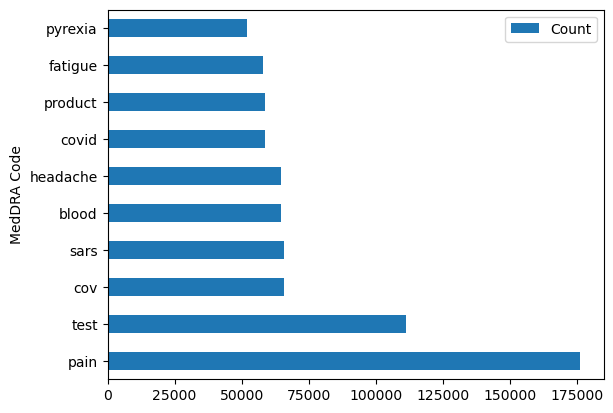

In [64]:
a = np.array(pbtcounts)
pfizerdata = pd.DataFrame(data = a, columns = ["MedDRA Code", "Count"])
pfizerdata['Count']=pfizerdata['Count'].astype(float)
pfizerplot = pfizerdata.plot.barh(x='MedDRA Code', y='Count')
print(pfizerdata)

  MedDRA Code     Count
0        pain  180404.0
1        site  165807.0
2   injection  130778.0
3     product   74873.0
4        test   73374.0
5    headache   65484.0
6     pyrexia   61533.0
7     fatigue   58995.0
8    swelling   57630.0
9        rash   54413.0


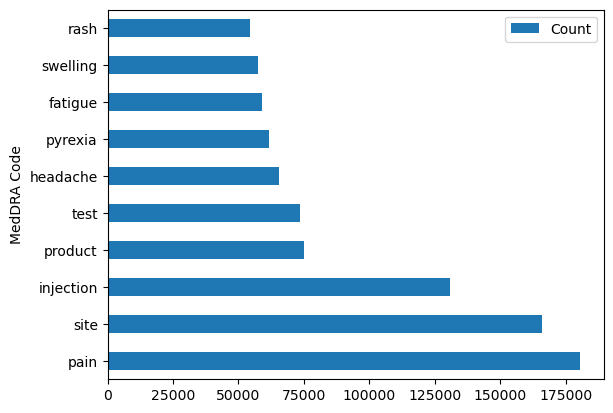

In [65]:
b = np.array(modernacounts)
modernadata = pd.DataFrame(data = b, columns = ["MedDRA Code", "Count"])
modernadata['Count'] = modernadata['Count'].astype(float)
modernaplot = modernadata.plot.barh(x='MedDRA Code', y='Count')
print(modernadata)

  MedDRA Code    Count
0        pain  34274.0
1    headache  16739.0
2        test  14514.0
3     pyrexia  14065.0
4       chill  11753.0
5     fatigue  11704.0
6       blood  11096.0
7   dizziness   8838.0
8      normal   8455.0
9      nausea   8443.0


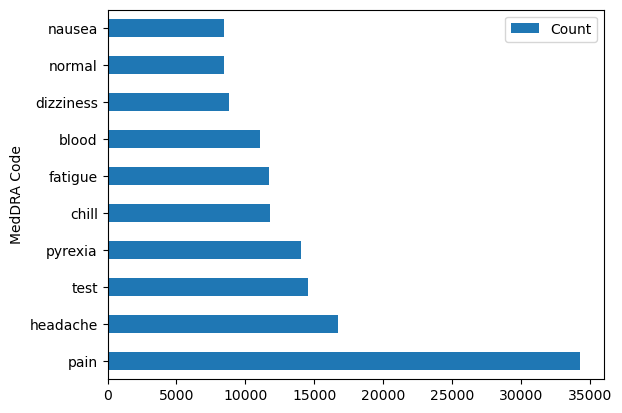

In [66]:
c = np.array(janssencounts)
janssendata = pd.DataFrame(data = c, columns = ["MedDRA Code", "Count"])
janssendata['Count'] = janssendata['Count'].astype(float)
janssenplot = janssendata.plot.barh(x='MedDRA Code', y='Count')
print(janssendata)

     MedDRA Code    Count
0           pain  10675.0
1        product   9124.0
2           site   8785.0
3      injection   8713.0
4           rash   3523.0
5        pyrexia   3479.0
6       swelling   3422.0
7  inappropriate   3387.0
8    vaccination   3266.0
9       erythema   3157.0


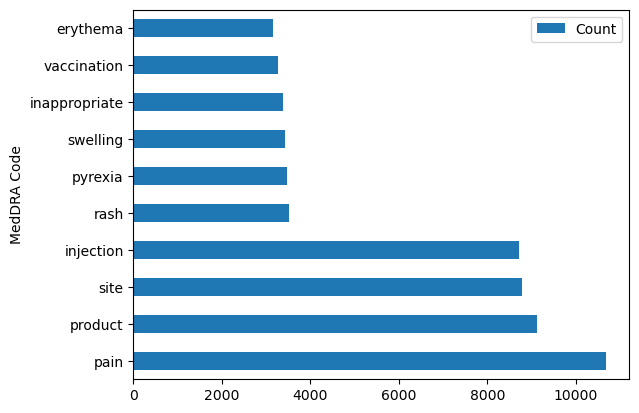

In [67]:
d = np.array(gskcounts)
gskdata = pd.DataFrame(data = d, columns = ["MedDRA Code", "Count"])
gskdata['Count'] = gskdata['Count'].astype(float)
gskplot = gskdata.plot.barh(x='MedDRA Code', y='Count')
print(gskdata)

     MedDRA Code    Count
0        product  10737.0
1          event   6373.0
2        adverse   6243.0
3          error   4908.0
4        storage   4632.0
5           site   4098.0
6      injection   3956.0
7           pain   2973.0
8           rash   2310.0
9  inappropriate   2067.0


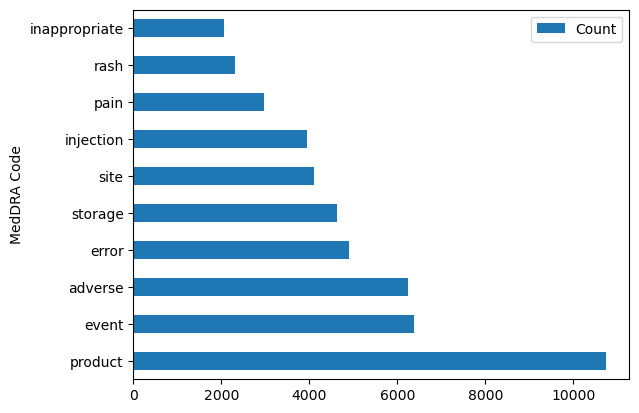

In [68]:
import numpy as np
e = np.array(merckcounts)
merckdata = pd.DataFrame(data = e, columns = ["MedDRA Code", "Count"])
merckdata['Count'] = merckdata['Count'].astype(float)
merckplot = merckdata.plot.barh(x='MedDRA Code', y='Count')
print(merckdata)